In [1]:
import datetime as dt
from typing import Dict, List, Tuple, Optional
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

pd.set_option('display.max_columns', None)
np.set_printoptions(precision=6)
np.set_printoptions(suppress=True)

In [2]:
df = pd.read_csv('test_ltv_ads.csv')
display(df.sample(5))
df.shape

,application_dm_id,install_dttm,country_code,media_source,device_type,is_trial,app_version,campaign_id,os_name,city,adset_id,ad_id,publisher_site_id,device_locale,impressions0,impressions1,impressions2,impressions3,revenue0,revenue1,revenue2,revenue3,target
77391,76,2020-04-14 21:38:22,27,1,1,0,168,1,1,665,1,1,1,19,0,0,0,0,0.000000,0.0,0.000000,0.0,0.000000
440675,14932,2020-03-12 20:05:47,2,10,1,0,208,638,1,242411,862,521,1,18,1,0,0,0,0.003415,0.0,0.000000,0.0,0.003415
99764,18,2020-04-03 05:40:09,114,1,1,0,22,1,1,7958,1,1,1,108,0,0,4,0,0.000000,0.0,0.000128,0.0,0.026137
194999,74,2020-03-30 04:28:58,15,1,1,0,141,1,1,563,1,1,1,2,0,0,0,0,0.000000,0.0,0.000000,0.0,0.000000
4987,29,2020-02-09 20:29:39,4,10,1,0,33,95,1,2522,27,105,1,4,0,0,0,0,0.000000,0.0,0.000000,0.0,0.000000


(500000, 23)

## Explore dataset

In [3]:
# Check Nan objects:
df.isna().sum()

application_dm_id    0
install_dttm         0
country_code         0
media_source         0
device_type          0
is_trial             0
app_version          0
campaign_id          0
os_name              0
city                 0
adset_id             0
ad_id                0
publisher_site_id    0
device_locale        0
impressions0         0
impressions1         0
impressions2         0
impressions3         0
revenue0             0
revenue1             0
revenue2             0
revenue3             0
target               0
dtype: int64

In [4]:
# Check duplicated:
df.duplicated().sum()

0

In [5]:
# Check statistics:
df[['revenue0', 'revenue1', 'revenue2', 'revenue3', 'target']].describe()

,revenue0,revenue1,revenue2,revenue3,target
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,0.106688,0.034041,0.014130,0.008515,0.201881
std,0.531220,0.330208,0.189734,0.145485,1.212041
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.032137,0.000000,0.000000,0.000000,0.057732
max,48.102741,54.525685,32.721868,35.611892,192.515075


> Для оценки данных будем использовать медиану, т.к. она является робастной характеристикой, далее по тексту, если я буду писать "среднее", то это будет обозначать именно медиану.

Итак, мы можем заметить, что среднее общей выручки равно 0 и это вполне нормально, т.к. обычно доля конверсионных пользователей небольшая. Однако меня смущает, что максимальное количество прибыли 192 - слишком большой значение, похожее на выброс. Возможно, это и не ошибка, а просто очень щедрый пользователь :)

Если искать выбросы стандартным методом, основанным на межквантильном диапазоне, то их получается слишком много:

In [6]:
def find_outlier(target: pd.Series, coef: int = 3) -> float:
    """Outlier detection with interquartile distance."""

    target = target.dropna()
    
    # Calculate statistics:
    median = target.median()
    Q1 = target.quantile(0.25)
    Q3 = target.quantile(0.75)
    
    # External_borders:
    interquartile_range = Q3 - Q1
    limit = Q3 + interquartile_range * coef
    
    print(f'Количество выбросов на всём датасете: {(target > limit).sum()}')
    print(f'Процент выбросов: {round((target > limit).sum()/len(target)*100, 2)}%')
    return limit

In [7]:
find_outlier(df['target']);

Количество выбросов на всём датасете: 65615
Процент выбросов: 13.12%


Скорее всего, это связано со спецификой данных, поэтому посмотрим на 99 квантиль:

In [8]:
df['target'].quantile(q=0.99)

3.4763382495286472

Я не знаю, в какой это валюте, но выглядит вполне адекватно. Для успокоения, посмотрим ещё на самую большую выручку:

In [9]:
df[df['target'] > 100]

,application_dm_id,install_dttm,country_code,media_source,device_type,is_trial,app_version,campaign_id,os_name,city,adset_id,ad_id,publisher_site_id,device_locale,impressions0,impressions1,impressions2,impressions3,revenue0,revenue1,revenue2,revenue3,target
206539,4907,2020-02-18 06:40:41,2,10,1,0,3,1074,2,331,1753,352,1,2,22,66,27,11,6.888369,20.652343,8.181409,3.127619,125.808197
214985,70,2020-02-19 07:27:52,139,1,1,0,188,1,2,14819,1,1,1,1044,399,289,166,123,42.328566,25.636690,17.225631,12.589174,107.470255
218479,8595,2020-04-08 10:02:03,87,6,1,0,47,1200,2,5092,1,465,7605,55,115,98,61,58,23.555099,14.334841,7.803234,11.142024,101.767651
228474,16792,2020-04-10 16:52:59,100,10,1,0,209,1254,2,18563,2034,533,1,85,246,144,214,50,24.062045,9.929247,17.122933,7.687355,192.515075
326837,70,2020-04-16 09:38:51,139,27,1,0,200,1,2,45276,1,1,1,150,152,129,30,112,27.414717,21.231541,5.526812,21.601291,108.696241
372781,8595,2020-03-15 14:06:59,61,8,1,0,389,1188,2,58769,1,460,12273,58,414,42,49,41,4.456880,0.917066,0.983319,1.018902,134.516467
399092,8595,2020-02-12 16:26:13,139,1,1,0,387,1,2,44546,1,1,1,1296,209,190,22,21,19.281690,17.502417,2.470584,1.852451,104.630235


В принципе, это не похоже на выбросы, практически все юзеры начинали приносить деньги с первого дня и продолжали вносить большие суммы на протяжении оставшихся 3 дней. Единственное, меня смущает - юзер под номером  `372781`: он выделяется среди остальных, т.к. не был таким активным в первые дни как остальные, однако, возможно, он "исправился" позже. Кстати, можно заметить, что у нас три страны под номером  `139`  - больше всего любят смотреть рекламу? :)

Процентное распределение по странам можно увидеть ниже:

In [10]:
df['country_code'].value_counts(normalize=True).head(10).mul(100).round(2).astype('str') + '%'

3      12.09%
4       9.99%
2       9.58%
21      5.72%
139     4.05%
31       3.1%
45      2.97%
25      2.57%
27      2.51%
52      2.48%
Name: country_code, dtype: object

Кстати, с учётом того, что пользователи из страны под номером `139` занимают в таблицу выше количественное преимущество, на общем рейтинге выручки это не сказывается:

In [11]:
df.groupby('country_code').agg({'target': 'mean'}).sort_values(by='target', ascending=False).head()

,target
country_code,
100,0.889436
2,0.756858
81,0.720079
75,0.673974
61,0.651708


А вот с типом приложения `8595` ситуация немного другая:

In [12]:
display(df.groupby('application_dm_id').agg({'target': 'mean'}).sort_values(by='target', ascending=False).head())
print(
    f'Доля приложения `8595` составляет {round(len(df[df["application_dm_id"] == 8595])/len(df) * 100, 2)}% '
    f'из всех {len(df["application_dm_id"].unique())} приложений.'
)

,target
application_dm_id,
8595,1.570775
70,1.390923
125,1.247088
16792,1.061418
4907,0.876255


Доля приложения `8595` составляет 1.77% из всех 77 приложений.


Посмотрим ещё немного на наши категориальные переменные:

In [13]:
df['os_name'].value_counts(normalize=True).head(10).mul(100).round(2).astype('str') + '%'

1    80.29%
2    19.71%
Name: os_name, dtype: object

Наверное, 80% это Android :)

In [14]:
df['application_dm_id'].value_counts(normalize=True).head(10).mul(100).round(2).astype('str') + '%'

74       18.71%
76        9.25%
27        8.83%
18        7.63%
29        6.45%
5234      4.53%
9541      4.33%
30        4.04%
71        3.81%
14932     3.63%
Name: application_dm_id, dtype: object

Приложение под номером 74 преобладает над остальными, может это [Пианино - Симулятор фортепиано, музыка и игры](https://play.google.com/store/apps/details?id=com.gismart.realpianofree)?)

## Analyze dataset

Для анализа и последующего моделирования сгенерируем несколько новых временных признаков:

In [15]:
# Generate different time features:
df['install_dttm'] = pd.to_datetime(df['install_dttm'])  # convert str to datetime
df['install_week'] = df['install_dttm'].apply(lambda x: x.week)
df['install_month'] = df['install_dttm'].apply(lambda x: x.month) 
df['install_day'] = df['install_dttm'].apply(lambda x: x.day)
df['install_dayofweek'] = df['install_dttm'].apply(lambda x: x.dayofweek)
df['install_is_weekend'] = df['install_dttm'].apply(lambda x: x.weekday() > 4)

# Required variables:
months = {
    2: 'February',
    3: 'March',
    4: 'April'
}

days = {
    0: 'Mo',
    1: 'Tu',
    2: 'We',
    3: 'Th',
    4: 'Fr',
    5: 'Sa',
    6: 'Su'
}

Попробуем сгруппировать пользователям по дням недели и посмотреть, как меняется доход за первые 4 дня использования приложения в зависимости от дня установки:

In [16]:
def plot_revenue_from_dayofweek(df: pd.DataFrame, months: Dict[int, str], days: Dict[int, str]) -> None:

    cohorts = df.groupby(['install_month', 'install_dayofweek']) \
                [['revenue0', 'revenue1', 'revenue2', 'revenue3']] \
                .sum().reset_index()
    
    for month in cohorts['install_month'].unique():
        cohorts[cohorts['install_month'] == month] \
                .drop(['install_month', 'install_dayofweek'], axis=1) \
                .reset_index(drop=True).T \
                .rename(columns=days).plot(figsize=(9, 6))
        
        plt.title(f'Revenue for the first 4 days by day of the week for {months.get(month)}', fontsize=16)
        plt.grid(axis='both', alpha=0.5, ls='-.')
        plt.legend(fontsize=14)
        plt.xticks(range(4), range(4), fontsize=12)
        plt.xlabel('Day of using application', fontsize=14)
        plt.ylabel('Revenue', fontsize=14)
        plt.show()

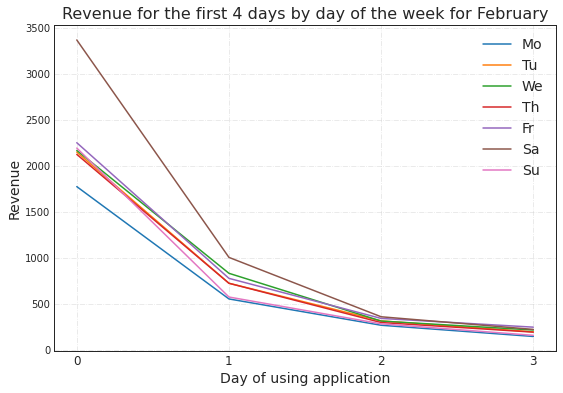

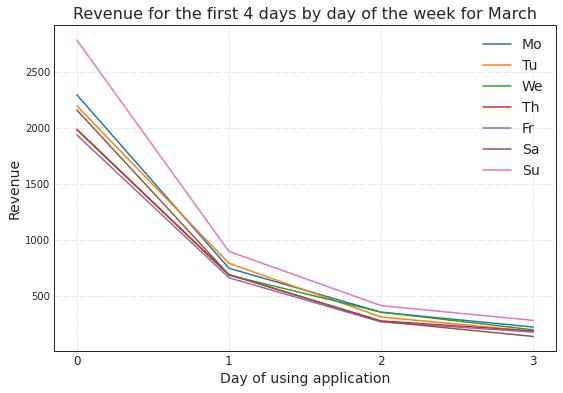

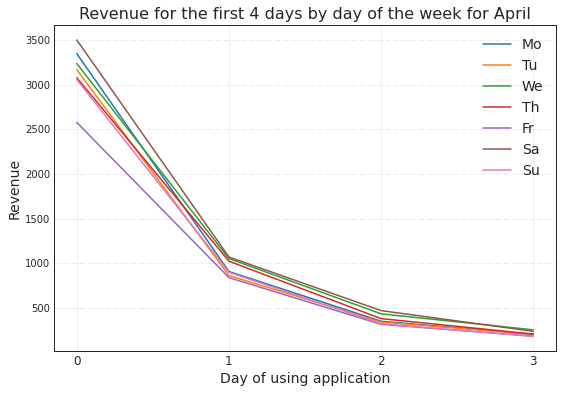

In [17]:
plot_revenue_from_dayofweek(df, months, days)

Если честно, даже немного обидно, т.к. я ожидал увидеть что-нибудь интересное, например, что пользователи, установившие приложение в выходные приносят больше денег. Хотя такой тренд прослеживается немного для первых двух графиках, но не думаю, что это будет статистически значимая разница. Зато хорошо прослеживается тенденция, что после первого дня использования приложения, пользователи начинают всё меньше и меньше приносить дохода

Теперь посмотрим, как суммарный менялся доход по неделям:

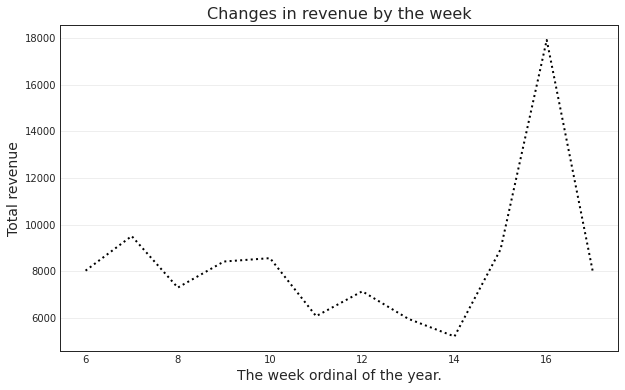

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(
    df.groupby(f'install_week').agg({'target': 'sum'})['target'],
    ':', color='black', linewidth=2
)
plt.title('Changes in revenue by the week', fontsize=16)
plt.ylabel('Total revenue', fontsize=14)
plt.xlabel('The week ordinal of the year.', fontsize=14)
plt.grid(axis='y', alpha=0.4)

Из графика видно, что последний 16 неделя дала хороший доход. Возможно, это связано с проведением какой-нибудь рекламной компании, благодаря чему больше пользователей установило приложения. Для проверки этой теории наложим два графика вместе: изменение суммарной выручки по неделям и количество пришедших пользователей:

In [19]:
def plot_distribution(df: pd.DataFrame, by: str) -> None:
    """
    The distribution of the number of installations by month
    or the week ordinal of the year.
    
    Parameters
    ----------
    df : pd.DataFrame
        Data for analysis.
    by : {'week', 'month'}
        Used to determine the groups for the groupby.
    """

    plt.figure(figsize=(12, 9))
    plt.plot(
        df.groupby(f'install_{by}', as_index=False).agg({'target': 'sum'})['target'],
        ':', color='black', alpha=0.8, linewidth=2, label='Total revenues'
    )
    sns.countplot(df[f'install_{by}'])
    if by == 'month':
        plt.xticks(range(3), ['February', 'March', 'May'])
    plt.xlabel(f'Installation {by}', fontsize=16)
    plt.ylabel('Number of installations', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(axis='y', alpha=0.4)
    plt.title(f'The distribution of the number of installations by {by}', fontsize=18)
    plt.show()

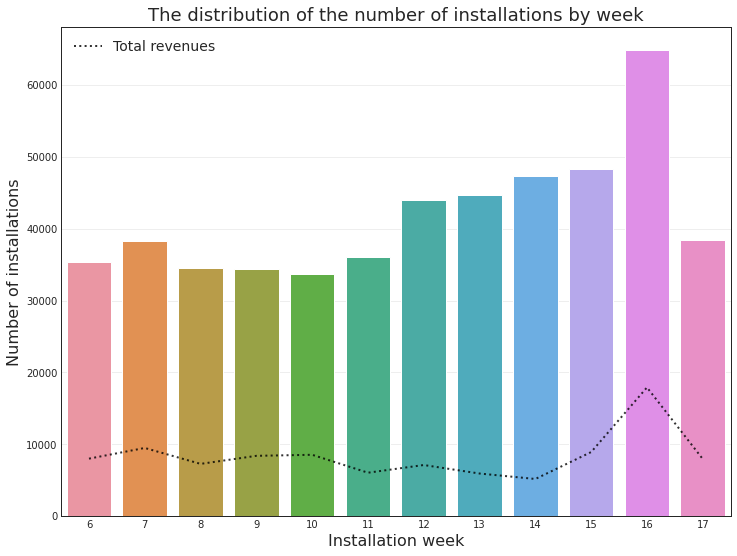

In [20]:
plot_distribution(df, 'week')

Видно, что этот пик как раз приходится на увеличение количества установок. При этом стоит отметить, что в `12`, `13` и `14` недели количество установок возрастало, но при этом суммарный доход немного падал.

Посмотрим теперь, что будет, если сгруппировать по месяцам:

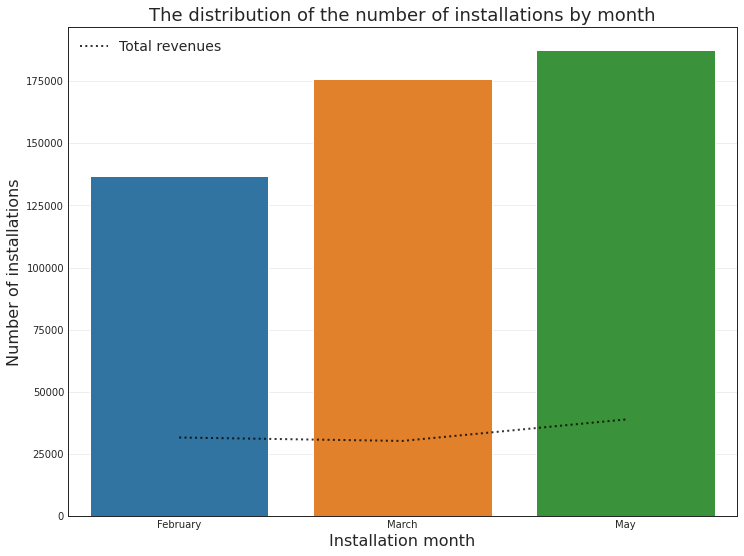

In [21]:
plot_distribution(df, 'month')

Здесь просто видно, что количество установок с каждым днём растёт, что может считаться хорошим показателем для компании.

До этого момента для группировки я использовал только время, хотя у нас есть большое признаковое пространство и можно провести анализ по когортному пространству, однако Влад сказал не упарываться, поэтому перейду к моделированию :)

## Modeling

Тестовое задание предполагает, что я построю простой baseline. Думаю сделать это в несколько этапов:
1. Первый baseline: одна общая модель на все данные - дёшево и сердито
2. Построить по простой модели на каждый когорт и посмотреть побьёт ли она 1 бейзлайн
3. Комбинация 1 и 2 пунктов

In [22]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor, CatBoostError
from sklearn.metrics import mean_absolute_error

In [23]:
X = df.drop(['target', 'install_dttm'], axis=1)
Y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [136]:
%%time
number_of_cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25]
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=number_of_cat_features)
test_pool = Pool(X_test, 
                 cat_features=number_of_cat_features) 

model = CatBoostRegressor(
    iterations=400,
    loss_function="MAPE",  # MAE
    depth=7,
    learning_rate=0.1,
    task_type="CPU",
    l2_leaf_reg=5,
    early_stopping_rounds=10,
    od_type="Iter",
    border_count=32,
    random_seed=42,
    verbose=0
)

model.fit(train_pool);

CPU times: user 15min 44s, sys: 46 s, total: 16min 30s
Wall time: 6min 35s


In [137]:
model.best_score_

{'learn': {'MAPE': 0.030464619005266046}}

Для оценки модели предлагается использовать MAPE, можно попробовать её реализовать вручную, однако, как отмечается на [Stack Exchange](https://stats.stackexchange.com/questions/299712/what-are-the-shortcomings-of-the-mean-absolute-percentage-error-mape) или в [Википедии](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error#Alternative_MAPE_definitions) существует проблеме деления на ноль:

In [77]:
def mean_absolute_percentage_error(y_true: pd.Series, y_pred: np.ndarray) -> float:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [78]:
y_pred = model.predict(test_pool)
mean_absolute_percentage_error(y_test, y_pred)

/home/ser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


inf

Мы можем попробовать использовать готовый алгоритм из sklearn (они [решают](https://github.com/scikit-learn/scikit-learn/blob/b4678ca8a/sklearn/metrics/_regression.py#L259) эту проблему, добавлением небольшого числа к знаменателю):
```python
from sklearn.metrics import mean_absolute_percentage_error
```

Однако для этого нужно [установить](https://scikit-learn.org/dev/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html) пока ещё нестабильную версию:
```bash
pip3 install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn
```

С учётом проблемотичности MAPE, я думаю, что удобнее будет обойтись MAE:

In [79]:
mean_absolute_error(y_test, y_pred)

0.10046508260909388

Выглядит неплохо`*`, теперь попробуем обойти этот бейзлайн.

Теперь посмотрим, на какие признаки модель обращала больше всего внимания:

In [134]:
def plot_feature_importances(feature_importances: np.ndarray, names: List[str], n: int = 10) -> None:
    """The individual importance values for each of the input features."""

    plt.figure(figsize=(10, 6))
    pd.Series(feature_importances, index=names) \
       .nlargest(n) \
       .plot(kind='barh')
    plt.grid(True, axis='x', alpha=0.3, linestyle='-')
    plt.title('Важность признаков', fontsize=16)
    plt.show()

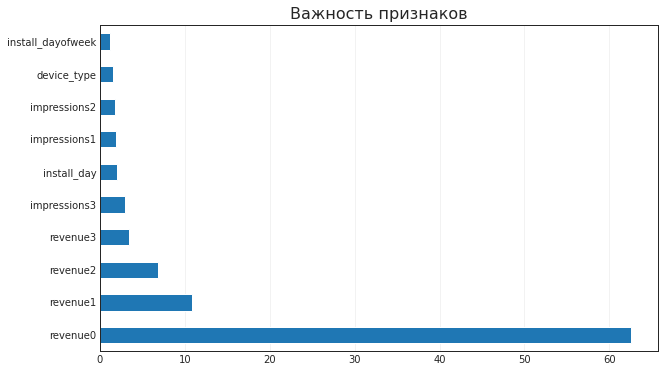

In [81]:
plot_feature_importances(model.feature_importances_, model.feature_names_)

Здесь тоже выглядит всё достаточно логично.

Теперь эту модель мы будем использовать в качестве первого baseline, который попробуем обойти.

Как будем обходить: есть идея сгруппировать по когортам и обучить индивидуальную модель на каждую группу. При этом я понимаю, что данных для обучения в большинстве групп будет крайне мало, для них я думаю использовать общую модель №1. Но для начала нужно убедиться, что модель обученная на определённой когорте показывает результат лучше, чем модель, обученная на всех данных.

Для начала сгруппируем всё по когортам  `Cohort dimensions: ['install_date', 'application_dm_id', 'country_code', 'media_source']`. В качестве install_date будет выступать день недели. Для начала посмотрим, сколько пользователей у нас попадает в такую группировку:

In [112]:
cohorts = df.groupby(['application_dm_id', 'country_code', 'media_source', 'install_dayofweek']).count()
cohorts.sort_values(by='target', ascending=False)

install_dttm  \
application_dm_id country_code media_source install_dayofweek                 
74                3            1            6                          3265   
                                            3                          3080   
                                            1                          3026   
                                            0                          2956   
                                            4                          2922   
...                                                                     ...   
126               71           1            2                             1   
                  69           3            5                             1   
                                            3                             1   
                                            1                             1   
22824             45           2            3                             1   

                                                               device_type  \
application_dm_id country_code media_source install_dayofweek                
74                3            1            6                         3265   
                                            3                         3080   
                                            1                         3026   
                                            0                         2956   
                                            4                         2922   
...                                                                    ...   
126               71           1            2                            1   
                  69           3            5                            1   
                                            3                            1   
                                            1                            1   
22824             45           2            3                            1   

                                                               is_trial  \
application_dm_id country_code media_source install_dayofweek             
74                3            1            6                      3265   
                                            3                      3080   
                                            1                      3026   
                                            0                      2956   
                                            4                      2922   
...                                                                 ...   
126               71           1            2                         1   
                  69           3            5                         1   
                                            3                         1   
                                            1                         1   
22824             45           2            3                         1   

                                                               app_version  \
application_dm_id country_code media_source install_dayofweek                
74                3            1            6                         3265   
                                            3                         3080   
                                            1                         3026   
                                            0                         2956   
                                            4                         2922   
...                                                                    ...   
126               71           1            2                            1   
                  69           3            5                            1   
                                            3                            1   
                                            1                            1   
22824             45           2            3                            1   

                             

Максимально 3 тысячи записей в одну когорту, в принципе, уже неплохо. Теперь узнаем, сколько записей будет, где количество человек больше 1000:

In [113]:
(cohorts['install_dttm'] > 1000).sum()

8

Что ж... Не очень много. Но 1000 - это просто цифра из головы, возможно, можно построить модель и с меньшим, количеством данных, например, взять порог 800 или 500.
Теперь нужно посмотреть, получается ли у нас получить лучшее качество:

In [114]:
def prepare_cohorts(cohorts: pd.DataFrame) -> List[pd.DataFrame]:
    cohorts_storage: List[pd.DataFrame] = []

    for application_dm_id, country_code, media_source, dayofweek in cohorts.index:
        tmp = df[
             (df['application_dm_id'] == application_dm_id) & \
             (df['country_code'] == country_code) & \
             (df['media_source'] == media_source) & \
             (df['install_dayofweek'] == dayofweek)
         ]
        cohorts_storage.append(tmp)

    return cohorts_storage

In [115]:
cohorts_storage = prepare_cohorts(cohorts[cohorts['install_dttm'] > 1000])
cohorts_storage[0].head()

,application_dm_id,install_dttm,country_code,media_source,device_type,is_trial,app_version,campaign_id,os_name,city,adset_id,ad_id,publisher_site_id,device_locale,impressions0,impressions1,impressions2,impressions3,revenue0,revenue1,revenue2,revenue3,target,install_week,install_month,install_day,install_dayofweek,install_is_weekend
441,74,2020-04-13 12:31:23,3,1,1,0,141,1,1,44483,1,1,1,11,0,0,0,0,0.0,0.0,0.0,0.0,0.0,16,4,13,0,False
657,74,2020-04-06 09:38:44,3,1,1,0,141,1,1,49268,1,1,1,2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,15,4,6,0,False
876,74,2020-04-06 11:32:41,3,1,1,0,141,1,1,3641,1,1,1,2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,15,4,6,0,False
967,74,2020-04-06 11:21:43,3,1,1,0,141,1,1,81455,1,1,1,11,0,0,0,0,0.0,0.0,0.0,0.0,0.0,15,4,6,0,False
1436,74,2020-02-17 15:32:31,3,1,1,0,141,1,1,377,1,1,1,115,0,0,0,0,0.0,0.0,0.0,0.0,0.0,8,2,17,0,False


Теперь обучим модель для каждой группы:

In [116]:
def prepare_cohorts_models(cohorts_storage: List[pd.DataFrame]) -> Tuple[List[CatBoostRegressor], List[Tuple[pd.Series, pd.Series]]]:
    number_of_cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25]
    models_storage: List[CatBoostRegressor] = []
    test_storage: List[Tuple[pd.Series, pd.Series]] = []
        
    for df_ in cohorts_storage:
        print(df_.shape[0], '-- drop_duplicates -->', end=' ')
        df_ = df_.drop(['install_dttm'], axis=1).drop_duplicates()
        print(df_.shape[0])
        X = df_.drop('target', axis=1)
        Y = df_['target']
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
        test_storage.append((X_test, y_test))
        
        train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=number_of_cat_features)
        test_pool = Pool(X_test, 
                  cat_features=number_of_cat_features)
        model = CatBoostRegressor(
            iterations=350,
            loss_function="MAE",
            depth=4,
            learning_rate=0.1,
            task_type="CPU",
            l2_leaf_reg=5,
            early_stopping_rounds=5,
            od_type="Iter",
            border_count=32,
            random_seed=42,
            verbose=0
        )
        try:
            model.fit(train_pool)
        except CatBoostError as err:
            print(' '.join(str(err).split()[1:]), end='\n\n')
            continue
        print(model.best_score_['learn'], end='\n\n')
        models_storage.append(model)
        
    return models_storage, test_storage

In [117]:
models_storage, _ = prepare_cohorts_models(cohorts_storage)

2956 -- drop_duplicates --> 2369
All train targets are equal

3026 -- drop_duplicates --> 2392
All train targets are equal

2910 -- drop_duplicates --> 2357
All train targets are equal

3080 -- drop_duplicates --> 2450
All train targets are equal

2922 -- drop_duplicates --> 2338
All train targets are equal

2893 -- drop_duplicates --> 2323
All train targets are equal

3265 -- drop_duplicates --> 2568
All train targets are equal

1495 -- drop_duplicates --> 901
All train targets are equal



К сожалению, все пользователи этих когорт не принесли в итоге никакого дохода. Это не значит, что пользователи из этих групп никогда не принесут доход, возможно, у нас просто недостаточно исторических данных ля моделирования.

Попробуем посмотреть, есть ли сегменты с достаточно большим количеством пользователей, которые при этом приносят деньги:

In [118]:
df.head()

,application_dm_id,install_dttm,country_code,media_source,device_type,is_trial,app_version,campaign_id,os_name,city,adset_id,ad_id,publisher_site_id,device_locale,impressions0,impressions1,impressions2,impressions3,revenue0,revenue1,revenue2,revenue3,target,install_week,install_month,install_day,install_dayofweek,install_is_weekend
0,18,2020-04-05 15:07:39,44,6,1,0,22,6,1,765,1,8,103,11,25,0,0,0,0.020042,0.000000,0.000000,0.000000,0.020042,14,4,5,6,True
1,18,2020-02-16 21:33:12,52,1,1,0,4,1,1,120175,1,1,1,27,10,59,24,20,0.020169,0.111984,0.032424,0.098230,0.313710,7,2,16,6,True
2,9541,2020-03-05 01:31:00,25,10,1,0,215,552,1,29830,705,453,1,2,23,0,0,3,5.190124,0.000000,0.000000,0.604506,5.794630,10,3,5,3,False
3,74,2020-04-21 12:35:21,71,1,1,0,141,1,1,920,1,1,1,77,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,17,4,21,1,False
4,3753,2020-03-05 13:31:54,2,1,1,0,3,1,2,44647,1,1,1,2,5,12,5,5,0.003989,0.238139,0.063731,0.068518,0.571443,10,3,5,3,False


In [119]:
group = df.groupby(['application_dm_id', 'country_code', 'media_source', 'install_dayofweek']) \
            .agg({'os_name': 'count', 'target': 'sum'}) \
            .rename(columns={'os_name': 'count'}) \
            .sort_values(by='count', ascending=False)
group = group[group['target'] > 0]
group.head(10)

count  \
application_dm_id country_code media_source install_dayofweek          
27                3            1            6                    999   
                                            3                    937   
                                            1                    933   
                                            5                    917   
                                            2                    875   
                                            4                    859   
                                            0                    830   
29                4            5            5                    817   
                                            3                    793   
                                            2                    760   

                                                                  target  
application_dm_id country_code media_source install_dayofweek             
27                3            1            6                  24.275763  
                                            3                  22.823932  
                                            1                  24.144238  
                                            5                  23.523939  
                                            2                  20.843351  
                                            4                  20.787838  
                                            0                  20.410477  
29                4            5            5                  24.281450  
                                            3                  20.555134  
                                            2                  18.882771

Ну такие есть, можно попробовать обучиться на них и посмотреть, что получится. Хотя данных становится уже маловато...

In [120]:
cohorts_storage = prepare_cohorts(group.head(10))
cohorts_storage[0].head()

,application_dm_id,install_dttm,country_code,media_source,device_type,is_trial,app_version,campaign_id,os_name,city,adset_id,ad_id,publisher_site_id,device_locale,impressions0,impressions1,impressions2,impressions3,revenue0,revenue1,revenue2,revenue3,target,install_week,install_month,install_day,install_dayofweek,install_is_weekend
838,27,2020-04-19 09:28:34,3,1,1,0,22,1,1,1494,1,1,1,11,42,0,0,0,0.036573,0.0,0.0,0.0,0.036573,16,4,19,6,True
2498,27,2020-03-29 12:45:07,3,1,1,0,4,1,1,320,1,1,1,3,147,0,0,0,0.141026,0.0,0.0,0.0,0.141026,13,3,29,6,True
2796,27,2020-03-01 08:36:51,3,1,1,0,7,1,1,9706,1,1,1,2,21,0,0,0,0.032584,0.0,0.0,0.0,0.032584,9,3,1,6,True
3242,27,2020-04-05 18:29:25,3,1,1,0,4,1,1,1167,1,1,1,2,1,0,0,0,0.003351,0.0,0.0,0.0,0.003351,14,4,5,6,True
3557,27,2020-02-09 02:04:49,3,1,1,0,7,1,1,42977,1,1,1,11,61,0,0,0,0.077997,0.0,0.0,0.0,0.077997,6,2,9,6,True


In [121]:
models_storage, test_storage = prepare_cohorts_models(cohorts_storage)

999 -- drop_duplicates --> 995
{'MAE': 0.004207624793717471}

937 -- drop_duplicates --> 932
{'MAE': 0.0040656463208407}

933 -- drop_duplicates --> 925
{'MAE': 0.005159875057015435}

917 -- drop_duplicates --> 914
{'MAE': 0.005582561645209377}

875 -- drop_duplicates --> 873
{'MAE': 0.004733605459834564}

859 -- drop_duplicates --> 855
{'MAE': 0.004402270683270713}

830 -- drop_duplicates --> 825
{'MAE': 0.0045319164764086265}

817 -- drop_duplicates --> 797
{'MAE': 0.0031194430011649023}

793 -- drop_duplicates --> 772
{'MAE': 0.003663744756129627}

760 -- drop_duplicates --> 732
{'MAE': 0.0029008946259772893}



А теперь попробуем сравнить, что лучше: общая модель или модель обученная под конкретный сегмент?

In [122]:
assert(len(models_storage) == len(test_storage))

stage = 0
stage_storage: Dict[int, CatBoostRegressor] = {}

for model_, test in zip(models_storage, test_storage):
    X_test_ = test[0]
    y_test_ = test[1]

    MAE_big = mean_absolute_error(y_test_, model.predict(X_test_))
    MAE_coh = mean_absolute_error(y_test_, model_.predict(X_test_))

    if MAE_big < MAE_coh:
        print('Общая модель лучше')
    else:
        print('Модель по сегментам лучше')

    stage_storage[stage] = model if MAE_big < MAE_coh else model_
    stage += 1

Модель по сегментам лучше
Модель по сегментам лучше
Общая модель лучше
Модель по сегментам лучше
Общая модель лучше
Общая модель лучше
Модель по сегментам лучше
Модель по сегментам лучше
Общая модель лучше
Модель по сегментам лучше


В принципе, оказывается моя идея имеет место быть. Конечно, же, нужно проводить более тщательное тестирование и проверять, а не переобучилиль ли маленькие модели. Но при этом, мне кажется, если ещё немного поиграться с параметрами или использовать разные алгоритмы, то маленькие модельки могут лучше предсказывать, чем одна большая.

Думаю, что это можно сделать так:
Нам приходят данные, мы определяем к какой когорте они относятся. Если для этой когорты было собрано достаточное количество исторических данных и у нас есть модель, то тут либо:
1. Мы предсказываем только когортной моделью
2. Либо делаем используем ансамбль из 2 моделей (большая и маленькая)

Если же исторических данных было мало и у нас нет подходящей модели, то просто предсказываем одной большой.
Я собирался реализовать эту логику, но из-за проблем на работе (писал Владу), я слишком поздно приступил к тестовому заданию и у меня просто не хватает на это времени :(

Вот что-то типо такого:

In [127]:
class CohortModels:
    def __init__(self, cohorts: pd.DataFrame, stage_storage: Dict[int, CatBoostRegressor], basic_model: CatBoostRegressor):
        self.cohorts = cohorts
        self.indexes = self.cohorts.index.values
        self.stage_storage = stage_storage
        self.basic_model = basic_model
    
    def __check_index(self, cohort: Tuple[int]) -> bool:
        return cohort in self.indexes
    
    def _return_model(self, cohort: Tuple[int]) -> CatBoostRegressor:
        index = -1
        if self.__check_index(cohort):
            index = list(self.indexes).index(cohort)
        return stage_storage.get(index, self.basic_model)
    
    def predict(self, df: pd.DataFrame) -> np.array:
        columns = ['application_dm_id', 'country_code', 'media_source', 'install_dayofweek']

        preds = []
        for _, row in tqdm(df.iterrows()):  # я знаю, что это ужасно, но у меня нет времени сделать красиво(
            cohort = tuple(row[columns])
            preds.append(self._return_model(cohort).predict(pd.DataFrame(row).T))

        return np.array(preds)

In [132]:
CM = CohortModels(group.head(10), stage_storage, model)
CM.predict(df.drop(['install_dttm', 'target'], axis=1).head(5))

/home/ser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


array([[ 0.021474],
       [ 0.305752],
       [ 1.751098],
       [-0.      ],
       [ 0.4322  ]])

Если смущает, что 4 строке модель предсказала отрицательное число, то это нормально: это особенность любого градиентного бустинга, происходит от того модели в ансамбле предсказывают ошибку предыдущих, а не целевую переменную. Подробнее расписано, например, [здесь](https://stats.stackexchange.com/questions/385447/how-well-gradient-boosting-can-predict-outside-training-values-domain) или можно посмотреть [тут](https://www.youtube.com/watch?v=UYDwhuyWYSo). В качестве решения в конце стоит просто добавить следующее:
```python
np.clip(y_pred, a_min=0)
```

***
P.S. Заметил уже в самом конце. Если в качестве функции потерь у основной модели указать MAE, а не MAPE, то она начинает обходить маленькие модели по качеству.